# CESNET Sampling and EDA

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

from skmultiflow.meta import AdaptiveRandomForestClassifier
from skmultiflow.data import DataStream
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

### Load QUICaid Benign Data

In [2]:
quicaid_df = pd.read_csv('benign.csv')
quicaid_df.dropna(inplace=True)
quicaid_df.astype(float)

,dst_port,dst_asn,quic_ver,dur,ratio,flow_pkt_rate,flow_byte_rate,total_pkts,total_bytes,max_bytes,min_bytes,ave_bytes,std_bytes,var_bytes,fwd_pkts,fwd_bytes,max_fwd_bytes,min_fwd_bytes,ave_fwd_bytes,std_fwd_bytes,var_fwd_bytes,rev_pkts,rev_bytes,max_rev_bytes,min_rev_bytes,ave_rev_bytes,std_rev_bytes,var_rev_bytes,max_iat,min_iat,ave_iat,std_iat,var_iat,fwd_dur,max_fwd_iat,min_fwd_iat,ave_fwd_iat,std_fwd_iat,var_fwd_iat,rev_dur,max_rev_iat,min_rev_iat,ave_rev_iat,std_rev_iat,var_rev_iat,label
0,443.0,13335.0,1.0,1.616348,0.0,12.373573,3154.023657,20.0,5098.0,1250.0,0.0,254.900000,433.052526,187534.490000,11.0,4301.0,1250.0,0.0,391.000000,527.273950,278017.818182,9.0,797.0,548.0,0.0,88.555556,163.198660,26633.802469,1.616348,3.452879e-02,0.174419,0.353735,0.125128,1.616348,1.616348,0.036507,0.244896,0.468212,0.219222,0.358289,0.358289,3.452879e-02,0.096112,0.094490,0.008928,0.0
1,443.0,13335.0,1.0,0.127682,1.0,234.958082,181967.202201,30.0,23234.0,1250.0,24.0,774.466667,518.012531,268336.982222,10.0,3962.0,1250.0,43.0,396.200000,463.846699,215153.760000,20.0,19272.0,1200.0,24.0,963.600000,433.144710,187614.340000,0.127682,2.388199e-02,0.089336,0.029452,0.000867,0.118107,0.118107,0.023882,0.072812,0.034301,0.001177,0.127682,0.127682,4.894717e-02,0.096772,0.023456,0.000550,0.0
2,443.0,13335.0,1.0,0.725707,1.0,41.339020,28331.008390,30.0,20560.0,1250.0,24.0,685.333333,506.651513,256695.755556,11.0,4086.0,1250.0,43.0,371.454545,471.419011,222235.884298,19.0,16474.0,1200.0,24.0,867.052632,431.956561,186586.470914,0.725707,5.600000e-08,0.391646,0.323268,0.104502,0.634333,0.634333,0.000411,0.256128,0.294598,0.086788,0.725707,0.725707,5.600000e-08,0.474463,0.311842,0.097245,0.0
3,443.0,13335.0,1.0,0.226025,0.0,132.728759,88105.349930,30.0,19914.0,1250.0,25.0,663.800000,539.200668,290737.360000,16.0,5634.0,1250.0,43.0,352.125000,482.684405,232984.234375,14.0,14280.0,1200.0,25.0,1020.000000,344.737374,118843.857143,0.226025,5.700000e-08,0.133763,0.089899,0.008082,0.224728,0.224728,0.183497,0.199391,0.011408,0.000130,0.226025,0.226025,5.700000e-08,0.052990,0.077739,0.006043,0.0
4,443.0,13335.0,1.0,0.172525,1.0,173.887621,157211.797788,30.0,27123.0,1200.0,24.0,904.100000,460.568008,212122.890000,6.0,4165.0,1048.0,45.0,694.166667,459.237200,210898.805556,24.0,22958.0,1200.0,24.0,956.583333,445.708884,198656.409722,0.172525,2.277578e-02,0.137804,0.054630,0.002984,0.146999,0.146999,0.022776,0.077448,0.045418,0.002063,0.172525,0.172525,2.566661e-02,0.153548,0.045018,0.002027,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190911,443.0,15169.0,1.0,29.998893,1.0,0.700026,278.976958,21.0,8369.0,1250.0,0.0,398.523810,519.646090,270032.058957,9.0,4391.0,1250.0,0.0,487.888889,554.387839,307345.876543,12.0,3978.0,1250.0,0.0,331.500000,481.211925,231564.916667,29.998893,8.472760e-04,1.731410,6.486004,42.068246,29.998893,29.998893,0.000847,3.922603,9.856434,97.149289,0.531961,0.531961,1.595114e-01,0.270615,0.112888,0.012744,0.0
190912,443.0,15169.0,1.0,30.044550,1.0,0.698962,278.652863,21.0,8372.0,1250.0,0.0,398.666667,519.558085,269940.603175,9.0,4394.0,1250.0,0.0,488.222222,554.141534,307072.839506,12.0,3978.0,1250.0,0.0,331.500000,481.211925,231564.916667,30.044550,7.674880e-04,1.734720,6.495724,42.194425,30.044550,30.044550,0.000767,3.929291,9.871166,97.439915,0.533189,0.533189,1.597567e-01,0.271673,0.113271,0.012830,0.0
190913,443.0,15169.0,1.0,18.291163,1.0,1.366780,598.048360,25.0,10939.0,1250.0,0.0,437.560000,542.243125,294027.606400,10.0,5649.0,1250.0,0.0,564.900000,573.220106,328581.290000,15.0,5290.0,1250.0,0.0,352.666667,502.965826,252974.622222,18.291163,1.077090e-04,0.976266,3.612301,13.048718,18.291163,18.291163,0.000108,2.186556,5.694979,32.432791,0.533138,0.533138,1.598943e-01,0.250091,0.109835,0.012064,0.0
190914,443.0,9821.0,1.0,0.252247,1.0,118.930827,45344.360008,30.0,11438.0,1250.0,0.0,38

### Load CESNET Data

In [ ]:
# TARGET_AVG = 29.648434  # Change this to your desired average
# MAX_ROWS = 200000

# columns = pd.read_csv('cesnet_dataset.csv', nrows=0).columns
# cesnet_df = pd.DataFrame(columns=list(columns))

# total_sum = 0
# total_count = 0

# for chunk in pd.read_csv('cesnet_dataset.csv', chunksize=100000):
#     lower_bound = max(1, TARGET_AVG - 1)  # Adjust bounds based on target
#     upper_bound = 30

#     filtered_chunk = chunk[
#         (chunk['total_pkts'] >= lower_bound) & 
#         (chunk['total_pkts'] <= upper_bound)
#     ]

#     # Update sum and count
#     new_total_sum = total_sum + filtered_chunk['total_pkts'].sum()
#     new_total_count = total_count + len(filtered_chunk)

#     # Ensure we do not exceed 200k rows
#     if new_total_count > MAX_ROWS:
#         excess_rows = new_total_count - MAX_ROWS
#         filtered_chunk = filtered_chunk.iloc[:-excess_rows]  # Trim extra rows
#         new_total_sum -= filtered_chunk['total_pkts'][-excess_rows:].sum()
#         new_total_count = MAX_ROWS
        
#     cesnet_df = pd.concat([cesnet_df, filtered_chunk], ignore_index=True)
#     total_sum, total_count = new_total_sum, new_total_count
    
#     if total_count == MAX_ROWS:
#         break

# cesnet_df.dropna(inplace=True)
# cesnet_df

In [ ]:
# cesnet_df.to_csv('reduced_cesnet.csv', index=None)

In [3]:
cesnet_df = pd.read_csv('reduced_cesnet.csv')
cesnet_df.dropna(inplace=True)
cesnet_df.astype(float)

,dst_port,dst_asn,quic_ver,dur,ratio,flow_pkt_rate,flow_byte_rate,total_pkts,total_bytes,max_bytes,min_bytes,ave_bytes,std_bytes,var_bytes,fwd_pkts,fwd_bytes,max_fwd_bytes,min_fwd_bytes,ave_fwd_bytes,std_fwd_bytes,var_fwd_bytes,rev_pkts,rev_bytes,max_rev_bytes,min_rev_bytes,ave_rev_bytes,std_rev_bytes,var_rev_bytes,max_iat,min_iat,ave_iat,std_iat,var_iat,fwd_dur,max_fwd_iat,min_fwd_iat,ave_fwd_iat,std_fwd_iat,var_fwd_iat,rev_dur,max_rev_iat,min_rev_iat,ave_rev_iat,std_rev_iat,var_rev_iat,label
0,443.0,15169.0,1.0,0.120209,0.0,174.695738,75160.761673,21.0,9035.0,1250.0,25.0,402.238095,520.887604,271323.895692,11.0,5640.0,1250.0,33.0,484.727273,577.181410,333138.380165,10.0,3395.0,1250.0,25.0,311.500000,433.139296,187609.650000,37.0,0.0,6.050000,10.106805,1.021475e+02,0.063,27.0,0.0,5.100000,8.129576,6.609000e+01,0.063,37.0,0.0,7.000000,11.679041,136.400000,0.0
1,443.0,15169.0,1.0,0.295548,1.0,71.054448,28333.807030,21.0,8374.0,1250.0,25.0,370.761905,489.042495,239162.562358,10.0,3995.0,1250.0,33.0,371.500000,506.165437,256203.450000,11.0,4379.0,1250.0,25.0,370.090909,472.937523,223669.900826,174.0,0.0,14.750000,37.768869,1.426487e+03,0.255,174.0,0.0,26.222222,53.395334,2.851062e+03,0.255,27.0,0.0,5.363636,8.070966,65.140496,0.0
2,443.0,15169.0,1.0,0.059789,0.0,317.784208,156567.261536,19.0,9361.0,1350.0,25.0,464.684211,561.597163,315391.373961,11.0,6417.0,1350.0,33.0,555.363636,608.381799,370128.413223,8.0,2944.0,1350.0,25.0,340.000000,461.817605,213275.500000,16.0,0.0,3.333333,4.725816,2.233333e+01,0.031,6.0,0.0,2.000000,2.144761,4.600000e+00,0.031,16.0,0.0,5.000000,6.284903,39.500000,0.0
3,443.0,15169.0,1.0,0.161979,0.0,111.125516,32405.435272,18.0,5249.0,1250.0,25.0,263.611111,401.049753,160840.904321,9.0,2366.0,1250.0,33.0,234.888889,390.932061,152827.876543,9.0,2883.0,1250.0,25.0,292.333333,408.905857,167204.000000,66.0,0.0,9.529412,16.532028,2.733080e+02,0.127,28.0,0.0,7.875000,10.397566,1.081094e+02,0.127,66.0,0.0,11.000000,20.385180,415.555556,0.0
4,443.0,15169.0,1.0,0.077508,0.0,141.920834,68212.313568,11.0,5287.0,1250.0,25.0,452.636364,529.011131,279852.776860,6.0,2887.0,1250.0,33.0,453.166667,563.729668,317791.138889,5.0,2400.0,1250.0,25.0,452.000000,484.072309,234326.000000,31.0,0.0,7.800000,10.107423,1.021600e+02,0.063,31.0,0.0,8.200000,11.889491,1.413600e+02,0.063,21.0,0.0,7.400000,7.914544,62.640000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,443.0,15169.0,1.0,0.157526,0.0,126.963168,34095.958762,20.0,5371.0,1250.0,25.0,240.550000,386.768338,149589.747500,10.0,2409.0,1250.0,33.0,212.900000,374.120154,139965.890000,10.0,2962.0,1250.0,25.0,268.200000,397.095152,157684.560000,41.0,0.0,8.263158,13.218178,1.747202e+02,0.063,38.0,0.0,6.000000,11.498792,1.322222e+02,0.063,41.0,0.0,10.300000,14.290206,204.210000,0.0
199996,443.0,36183.0,1.0,0.156773,0.0,114.815689,46819.286484,18.0,7340.0,1350.0,31.0,379.777778,472.958720,223689.950617,9.0,4229.0,1350.0,43.0,441.888889,508.559500,258632.765432,9.0,3111.0,1200.0,31.0,317.666667,425.478032,181031.555556,49.0,0.0,9.176471,13.814891,1.908512e+02,0.127,41.0,0.0,9.625000,12.999399,1.689844e+02,0.063,49.0,0.0,8.777778,14.489673,209.950617,0.0
199997,443.0,15169.0,1.0,0.115307,0.0,156.105007,62346.605150,18.0,7189.0,1250.0,25.0,371.388889,476.116715,226687.126543,9.0,3738.0,1250.0,33.0,387.333333,504.102944,254119.777778,9.0,3451.0,1250.0,25.0,355.444444,445.809404,198746.024691,39.0,0.0,6.823529,9.817363,9.638062e+01,0.063,18.0,0.0,6.250000,6.475917,4.193750e+01,0.031,39.0,0.0,7.333333,12.009256,144.222222,0.0
199998,443.0,15169.0,1.0,0.066755,1.0,254.662572,86120.889821,17.0,5749.0,1250.0,25.0,310.176471,430.562318,185383.910035,8.0,2558.0,1250.0,33.0,291.750000,436.924121,190902.687500,9.0,3191.0,1250.0,25.0,326.555556,424.155923,179908.246914,20.0,0.0,4.187500,6.207040,3.852734e+01,0.031,20.0,0.0,4.571429,6.630172,4.395918

In [7]:
# Take 10k samples from each dataset
quicaid_samples = quicaid_df.sample(n=100000, random_state=42)
cesnet_samples = cesnet_df.sample(n=100000, random_state=42)

# Create a new DataFrame by combining them
combined_df = pd.concat([quicaid_samples, cesnet_samples], ignore_index=True)

In [8]:
combined_df.to_csv('benign_cesnet.csv', index=False)

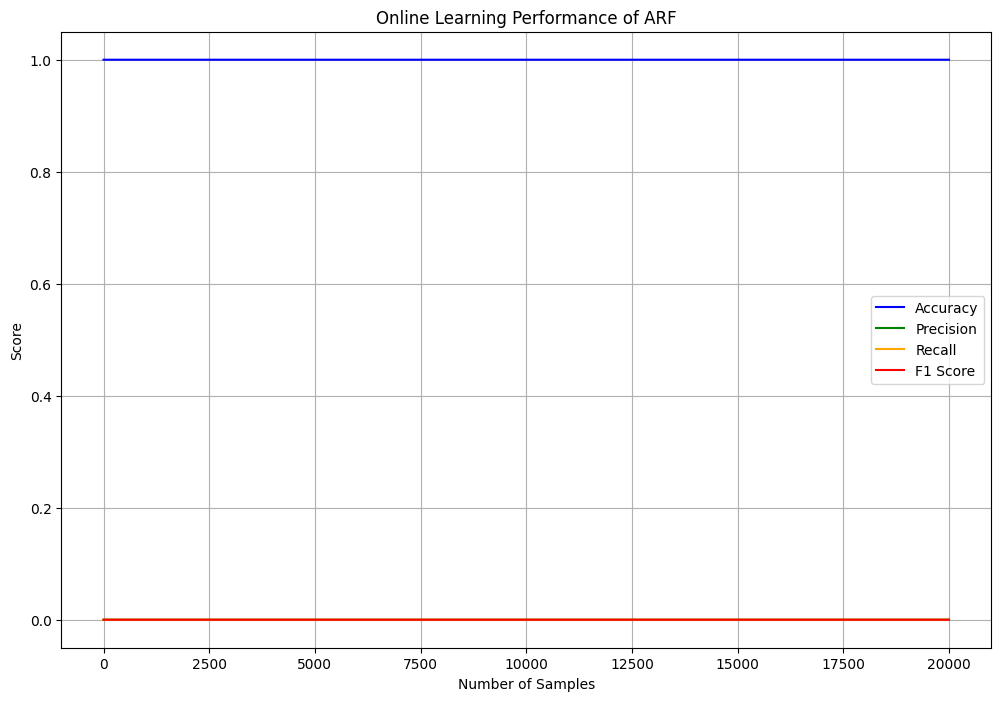

In [6]:
# Create a data stream
stream = DataStream(combined_df, target_idx=-1)

# Initialize the ARF classifier
clf = AdaptiveRandomForestClassifier(random_state=42)

# Store metrics over time
n_samples = 0
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []
sample_counts = []

# Online learning loop
while stream.has_more_samples():
    X_batch, y_batch = stream.next_sample()
    
    if n_samples > 0:
        # Predict and update metrics
        y_pred = clf.predict(X_batch)
        accuracy = accuracy_score(y_batch, y_pred)
        precision = precision_score(y_batch, y_pred, zero_division=0)
        recall = recall_score(y_batch, y_pred, zero_division=0)
        f1 = f1_score(y_batch, y_pred, zero_division=0)
        
        # Store metrics
        accuracy_list.append(accuracy)
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)
        sample_counts.append(n_samples)
    
    # Train the classifier
    clf.partial_fit(X_batch, y_batch, classes=[0, 1])
    n_samples += 1
    
    # Stop after processing all samples
    if n_samples == len(combined_df):
        break

# Plot the results
plt.figure(figsize=(12, 8))
plt.plot(sample_counts, accuracy_list, label='Accuracy', color='blue')
plt.plot(sample_counts, precision_list, label='Precision', color='green')
plt.plot(sample_counts, recall_list, label='Recall', color='orange')
plt.plot(sample_counts, f1_list, label='F1 Score', color='red')
plt.xlabel('Number of Samples')
plt.ylabel('Score')
plt.title('Online Learning Performance of ARF')
plt.legend()
plt.grid()
plt.show()

In [ ]:
quicaid_df['source'] = 'quicaid'
cesnet_df['source'] = 'cesnet'

In [ ]:
combined_df = pd.concat([quicaid_df, cesnet_df])

# Melt to long-form
long_df = combined_df.melt(id_vars=['source'], var_name='feature', value_name='value')

# Plot overlapping boxplots
plt.figure(figsize=(20, 15))
sns.boxplot(data=long_df, x='value', y='feature', hue='source')

plt.xscale('log')
plt.title('Overlapping Boxplot of Feature Distributions')
plt.show()

### EDA

In [ ]:
quicaid_df.describe()

In [ ]:
cesnet_df.describe()

In [ ]:
# import pandas as pd
# import numpy as np
# import seaborn as sns
# import matplotlib.pyplot as plt
# from scipy.stats import ks_2samp, chi2_contingency
# from scipy.spatial.distance import jensenshannon

# # Load datasets
# df1 = pd.read_csv("benign.csv")  # Simulated dataset
# df1.dropna(inplace=True)
# df2 = pd.read_csv("reduced_cesnet.csv")  # External dataset
# df2.dropna(inplace=True)

# # 1. Check for feature compatibility
# common_cols = list(set(df1.columns) & set(df2.columns))
# df1, df2 = df1[common_cols], df2[common_cols]

# print("Common columns:", common_cols)

# # 2. Compare summary statistics
# print("\nDataset 1 summary:")
# print(df1.describe())

# print("\nDataset 2 summary:")
# print(df2.describe())

# # 3. Compare distributions
# for col in common_cols:
#     if df1[col].dtype in ['float64', 'int64']:
#         plt.figure(figsize=(8, 4))
#         sns.kdeplot(df1[col], label='Dataset 1', shade=True)
#         sns.kdeplot(df2[col], label='Dataset 2', shade=True)
#         plt.title(f"Distribution of {col}")
#         plt.legend()
#         plt.show()
        
#         # KS Test
#         ks_stat, ks_p = ks_2samp(df1[col].dropna(), df2[col].dropna())
#         print(f"{col} - KS Test: Stat={ks_stat:.3f}, P-Value={ks_p:.3f}")
    
#     elif df1[col].dtype == 'object':  # Categorical
#         contingency_table = pd.crosstab(df1[col], df2[col])
#         chi2_stat, chi2_p, _, _ = chi2_contingency(contingency_table)
#         print(f"{col} - Chi-Square Test: Stat={chi2_stat:.3f}, P-Value={chi2_p:.3f}")

# # 4. Check for duplicates
# overlap = df1.merge(df2, how='inner')
# print("\nNumber of overlapping rows:", len(overlap))

# # 5. Measure Jensen-Shannon Divergence
# js_divergences = {}
# for col in common_cols:
#     if df1[col].dtype in ['float64', 'int64']:
#         hist1, _ = np.histogram(df1[col].dropna(), bins=50, density=True)
#         hist2, _ = np.histogram(df2[col].dropna(), bins=50, density=True)
#         js_div = jensenshannon(hist1, hist2)
#         js_divergences[col] = js_div
#         print(f"{col} - JS Divergence: {js_div:.3f}")

# # If JS Divergence is low (e.g., < 0.1), datasets are similar

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp, chi2_contingency
from scipy.spatial.distance import jensenshannon

# Load datasets
df1 = quicaid_df  # Simulated dataset
df2 = cesnet_df  # External dataset

# 1. Check for feature compatibility
common_cols = list(set(df1.columns) & set(df2.columns))
df1, df2 = df1[common_cols], df2[common_cols]

print("Common columns:", common_cols)

# 2. Compare summary statistics
print("\nDataset 1 summary:")
print(df1.describe())

print("\nDataset 2 summary:")
print(df2.describe())

# 3. Single Large Plot for Distribution Comparison (only when both datasets have data)
num_features = [
    col for col in common_cols 
    if df1[col].dtype in ['float64', 'int64'] and df1[col].dropna().size > 0 and df2[col].dropna().size > 0
]
num_plots = len(num_features)

if num_plots > 0:
    # Set up the figure with subplots
    rows = (num_plots // 4) + (num_plots % 4 > 0)  # Arrange in rows of 3 columns
    fig, axes = plt.subplots(rows, 4, figsize=(18, rows * 5))  # Adjust figure size dynamically
    axes = axes.flatten()  # Flatten to easily iterate

    for i, col in enumerate(num_features):
        sns.kdeplot(df1[col], label='Dataset 1', shade=True, ax=axes[i])
        sns.kdeplot(df2[col], label='Dataset 2', shade=True, ax=axes[i])
        axes[i].set_title(f"Distribution of {col}")
        axes[i].legend()

    # Hide unused subplots if any
    for i in range(num_plots, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()
else:
    print("No features have valid data in both datasets for comparison.")
